In [1]:
import sys
sys.path.insert(0, '..')
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm import tqdm
import threading
import functools

sigma = 2

from utils.kfp import diffusion_coeff, marginal_prob_std
from network.network import ScoreNet

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


error_tolerance = 1e-5

channels = 3
N = 20
H = 28
W = 28

In [2]:
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.tensor(np.linspace(1., eps, N))
  # Create the latent code
  if z is None:
    initial_x = torch.randn(batch_size, 1, H, W, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    initial_x = z + torch.randn(batch_size, 1, H, W, device=device) \
      * marginal_prob_std(t)[:, None, None, None]

  shape = initial_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), initial_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"\nNumber of function evaluations: {res.nfev}")
  x = [res.y[:, 0].reshape(shape)[0][None]]
  T = len(res.t)
  for i in range(N-1):
    idx = int(i + (T/N))
    x.append(res.y[:, idx].reshape(shape)[i][None])
  x.append(res.y[:, -1].reshape(shape)[-1][None])
  x = np.concatenate(x, axis = 0)
  return x

In [3]:
# function for sampling on a thread
def diffuse_sample(channel, samples, diffusion_coeff, marginal_prob_std):

  model_score = ScoreNet(marginal_prob_std=marginal_prob_std)
  file = f'../model_cifar_thread_{channel}.pth'
  ckpt = torch.load(file)
  model_score.load_state_dict(ckpt)
  model_score.eval();

  sample_batch_size = N
  sampler = ode_sampler

  # Generate samples using the specified sampler.
  output = sampler(model_score,
                  marginal_prob_std,
                  diffusion_coeff,
                  sample_batch_size)

  samples.append(output)


Number of function evaluations: 320

Number of function evaluations: 320

Number of function evaluations: 326
(0.017490947295016268, 1.4585422374807278)


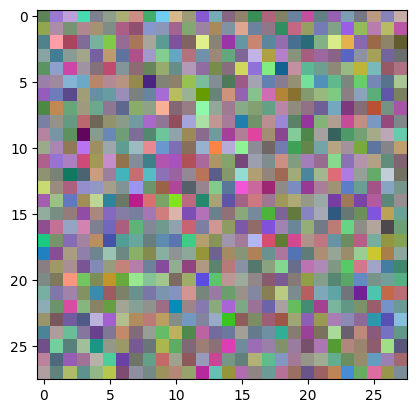

(0.037479272075726815, 1.3913766005651491)


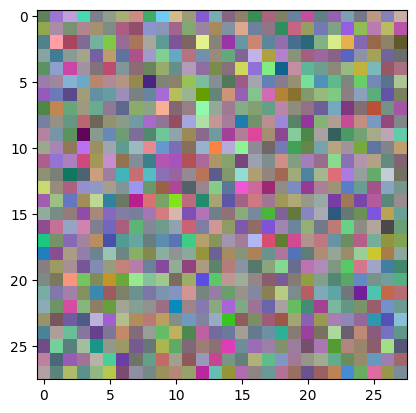

(0.019580304427194873, 1.2976483128238192)


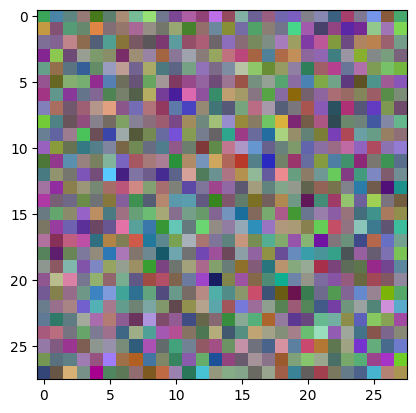

(0.053140278931381575, 1.231177779239682)


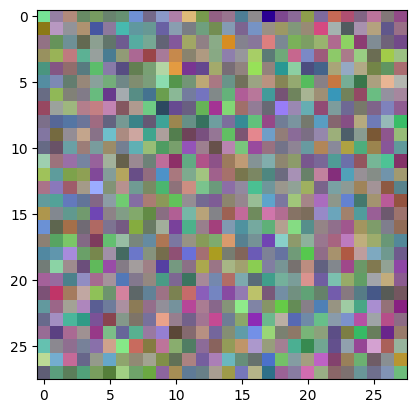

(0.025542632956654786, 1.1177187070593346)


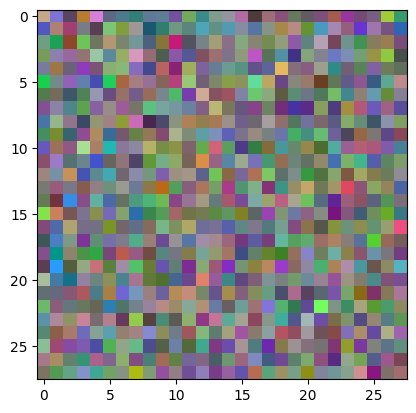

(0.10100231872240202, 1.0300518297741408)


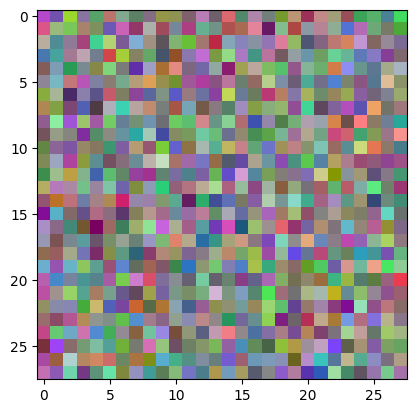

(0.09324726799122028, 0.9338116598997662)


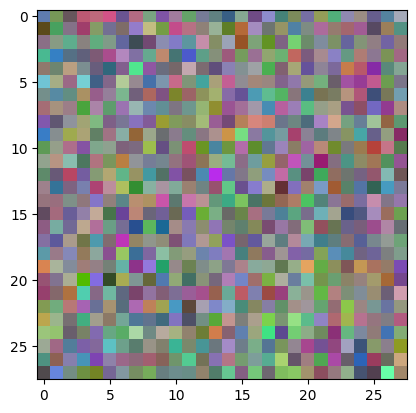

(0.08284237875521855, 0.8719350392216179)


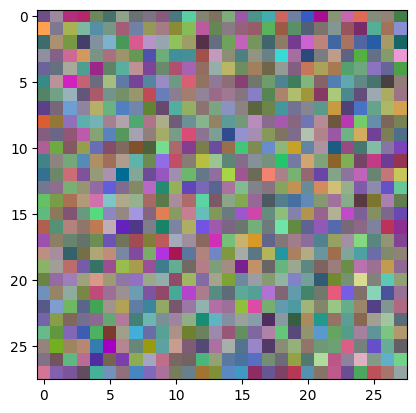

(0.07389561485169745, 0.7973212048417716)


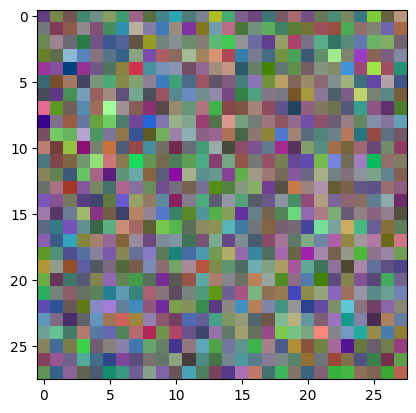

(0.0750150312321521, 0.7382919827952497)


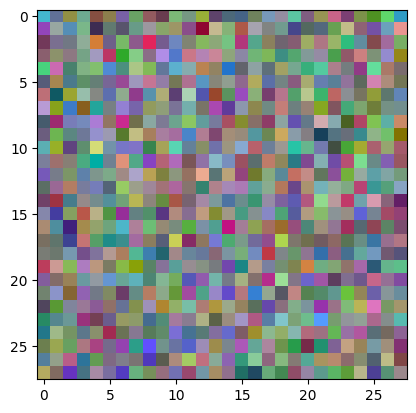

(0.09809434519315537, 0.6717385051835582)


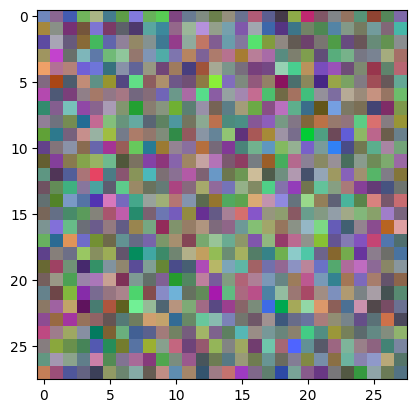

(0.12238701293798725, 0.6036632006257017)


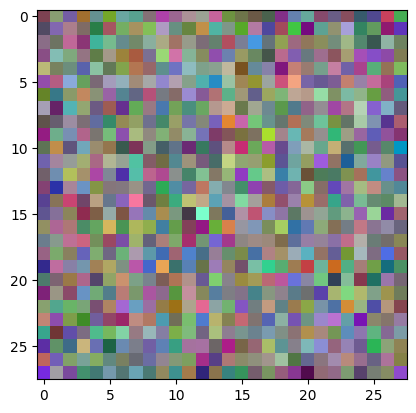

(0.12150456156787112, 0.5441751709749273)


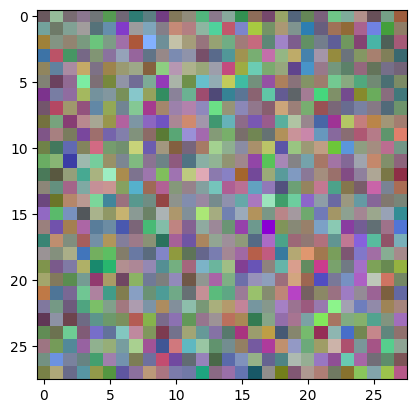

(0.15393181781348234, 0.5045274552248995)


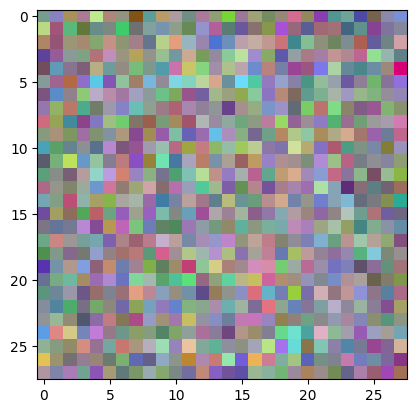

(0.15341312503277377, 0.43739438018491944)


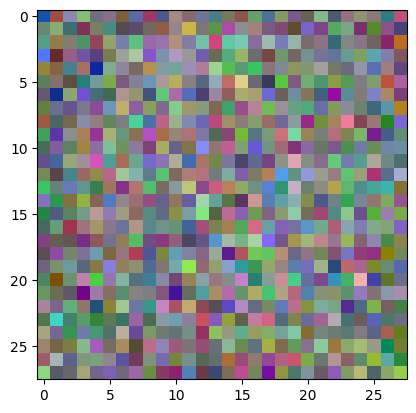

(0.15412624670178166, 0.37848930826033966)


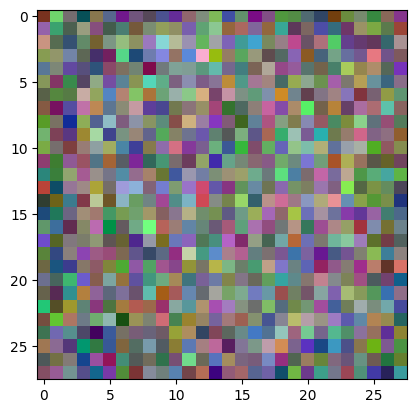

(0.16274275027306442, 0.3254351494737704)


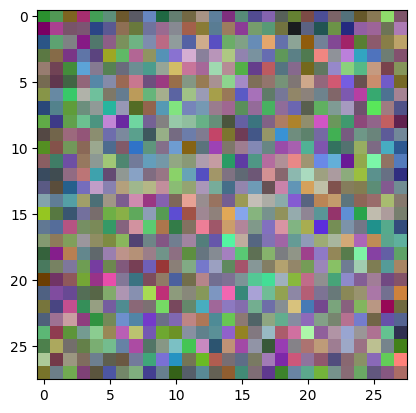

(0.1868132503276223, 0.27530290411746283)


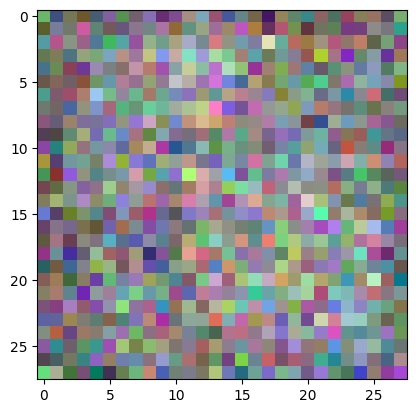

(0.17426609555073333, 0.2266335349950647)


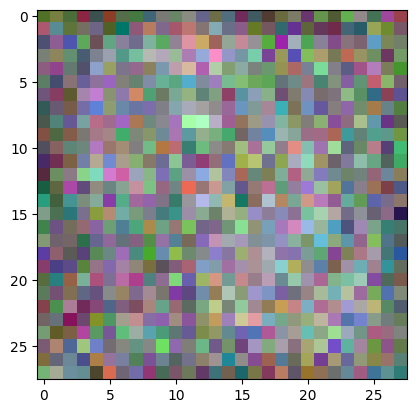

(0.18971948249883983, 0.1796584384337635)


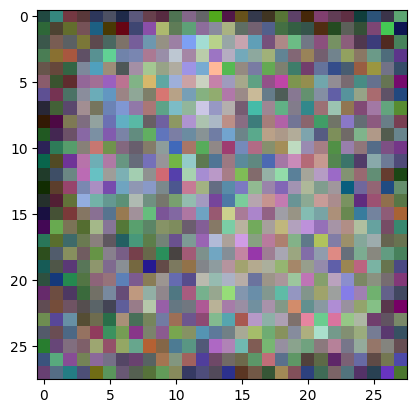

(0.3848393489392518, 0.17980004126497556)


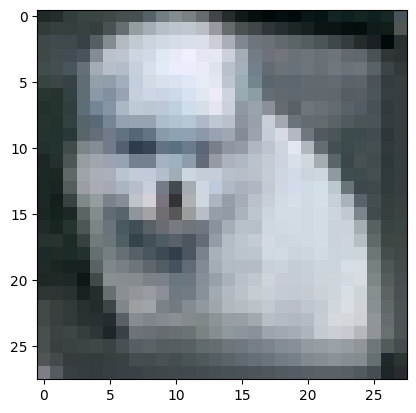

In [4]:
#@title Sample each channel on a thread
threads = [None] * channels
samples = []

# diffuse all three channels concurrently
for ch in range(channels):
  threads[ch] = threading.Thread(target=diffuse_sample, args=[ch, samples, diffusion_coeff_fn, marginal_prob_std_fn])
  threads[ch].start()

for thread in threads:
  thread.join()

samples = np.concatenate(samples, axis = 1)
for i in range(samples.shape[0]):
  print(f'{samples[i].mean(), samples[i].std()}')
  plt.imshow(((samples[i] - samples[i].min())/(samples[i].max() - samples[i].min())).transpose(1, 2, 0))
  plt.show()



MovieWriter ffmpeg unavailable; using Pillow instead.


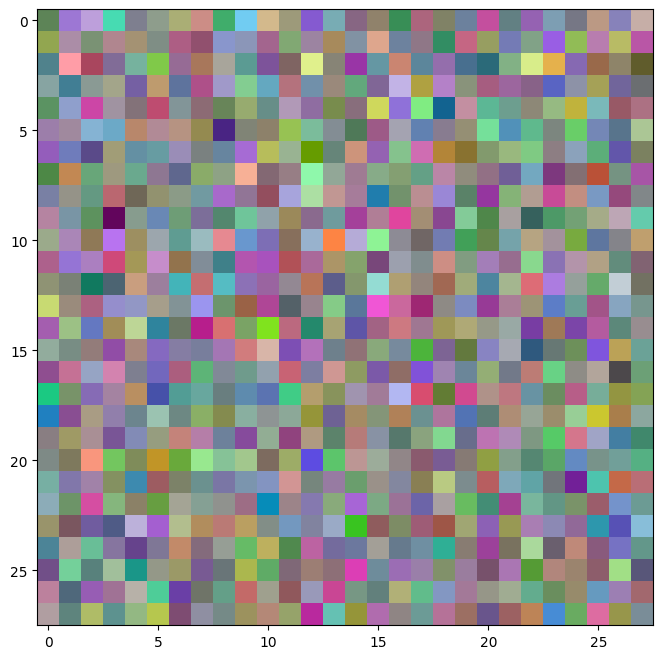

In [6]:
def get_frame(i):
  return ((samples[i] - samples[i].min())/(samples[i].max() - samples[i].min())).transpose(1, 2, 0)

fig = plt.figure(figsize=(8,8));

im = plt.imshow(get_frame(0), animated=True)

def frame(i):
  im.set_data(get_frame(i));

  return [im]

animation_fig = animation.FuncAnimation(fig, frame, frames=samples.shape[0], interval=10, blit=False,repeat_delay=2);

animation_fig.save("animation.gif");